In [1]:
!pip install -U spaCy
!python -m spacy download en_core_web_sm
!python -m spacy download it_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-05-07 17:20:24.492180: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 17:20:29.006271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2023-05-07 17:20:44.501844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operation

# Text Categorization

The goal is to classify documents according to a set of predifined classes (labels).

We need training data for training a supervised approaches.

The process for training a classifier:
1. Load training data
2. Data pre-processing
3. Create and extract features
4. Training a model 

For testing:
1. Load test data
2. Generate feature using the same approach adopted during the training
3. Classify test instances
4. Compute metrics

We use spaCy for text processing and scikit-learn for machine learning.

We define some functions for text processing.
We build also a class for implementing a custom Trasformer based on spaCy. This trasform will process the text.

In [2]:
import pandas as pd
import string
import spacy
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.lang.it.stop_words import STOP_WORDS
from spacy.lang.it import Italian
from sklearn import metrics
from sklearn import svm
from sklearn import neural_network
from sklearn.model_selection import KFold

#init spaCy
punctuations = string.punctuation
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

# Tokenizer function
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.text for word in mytokens ]
    # remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens

Training data loading and feature creation. We exploit BoW+TfIdf as features.

In [3]:
df_train = pd.read_csv('train.csv', sep=",", header=None, names=["label","text"])
#BoW with word count
#vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
#BoW with TF-IDF
vector = TfidfVectorizer(tokenizer = spacy_tokenizer)
X_train = df_train['text'] # the features
y_train = df_train['label'] # the labels
print(df_train.info)

<bound method DataFrame.info of          label                                               text
0         earn  champion products ch approves stock split cham...
1          acq  computer terminal systems cpml completes sale ...
2         earn  cobanco inc cbco year net shr cts vs dlrs net ...
3         earn  am international inc am nd qtr jan oper shr lo...
4         earn  brown forman inc bfd th qtr net shr one dlr vs...
...        ...                                                ...
5480      earn  kelly oil and gas partners kly year dec shr ct...
5481  money-fx  japan seeks to strengthen paris currency accor...
5482      earn  tcw convertible securities cvt sets dividend t...
5483  money-fx  south korean won fixed at month high the bank ...
5484      ship  australian unions launch new south wales strik...

[5485 rows x 2 columns]>


Build the model.

In [4]:
# Linear Support Vector Machine classifier
classifier = svm.LinearSVC()
# Multi-layer Perceptron classifier
#classifier = neural_network.MLPClassifier()
# Create the pipeline
pipe = Pipeline([("cleaner", predictors()),
('vectorizer', vector),
('classifier', classifier)])
# Fit the model
pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7fa520b3e740>),
                ('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7fa3fcd8db40>)),
                ('classifier', LinearSVC())])

Caricamento dei dati di test e generazione delle feature.

In [5]:
df_test=pd.read_csv('test.csv', sep=",", header=None, names=["label","text"])
X_test = df_test['text'] # the features
y_test = df_test['label'] # the labels

Compute predictions on the test set and calculate metrics.

In [6]:
predicted = pipe.predict(X_test)
acc = metrics.accuracy_score(y_test, predicted)
print("Accuracy:", acc)
precision = metrics.precision_score(y_test, predicted, average='macro')
recall = metrics.recall_score(y_test, predicted, average='macro')
fm = metrics.f1_score(y_test, predicted, average='macro')
print("P={0}, R={1}, F1={2}".format(precision, recall, fm))
print("======================================================")
print(metrics.classification_report(y_test, predicted, digits=4))

Accuracy: 0.9730470534490635
P=0.9417831350716893, R=0.915466933404202, F1=0.9275744791913121
              precision    recall  f1-score   support

         acq     0.9744    0.9828    0.9785       696
       crude     0.9580    0.9421    0.9500       121
        earn     0.9917    0.9935    0.9926      1083
       grain     1.0000    0.9000    0.9474        10
    interest     0.9067    0.8395    0.8718        81
    money-fx     0.8837    0.8736    0.8786        87
        ship     0.9062    0.8056    0.8529        36
       trade     0.9136    0.9867    0.9487        75

    accuracy                         0.9730      2189
   macro avg     0.9418    0.9155    0.9276      2189
weighted avg     0.9728    0.9730    0.9728      2189



Build the confusion matrix.

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted)
print(cm)

[[ 684    2    8    0    0    0    0    2]
 [   3  114    0    0    0    0    3    1]
 [   7    0 1076    0    0    0    0    0]
 [   0    0    0    9    1    0    0    0]
 [   0    0    0    0   68   10    0    3]
 [   3    0    1    0    6   76    0    1]
 [   4    3    0    0    0    0   29    0]
 [   1    0    0    0    0    0    0   74]]


Visualize the confusion matrix.

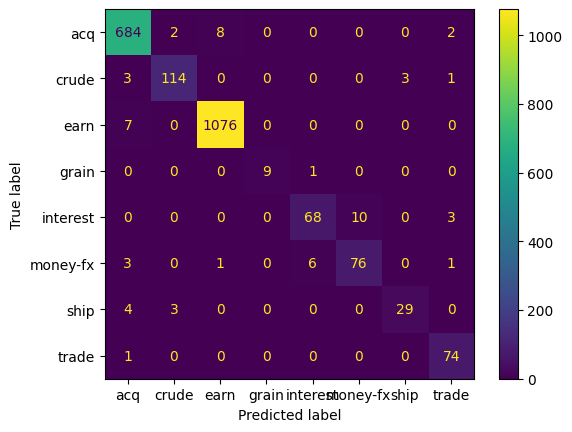

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

k-fold with k=5

In [10]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
fmicro = 0
fmacro = 0
for train_index, test_index in kf.split(X_train):
  pipe.fit(X_train[train_index], y_train[train_index])
  predicted = pipe.predict(X_train[test_index])
  fmacro = fmacro + metrics.f1_score(y_train[test_index], predicted, average='macro')
  fmicro = fmicro + metrics.f1_score(y_train[test_index], predicted, average='micro')
print("F-macro: ",fmacro/5)
print("F-micro: ",fmicro/5)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F-macro:  0.9338006697422696
F-micro:  0.9721057429352781


# Sentiment Analysis

We use text categorization approaches for solving the sentiment analysis task.
The text polarity is used as label (positive, negative, neutral).
For this experiment, we use data from EVALITA 2016 in particular data from the Sentipolc task.

In this dataset, texts come from Twitter (tweets). Each tweet has three binary labels:
1. subj: 0=no subjectivity, 1=subjectivity
2. opos: 0=no positive polarity, 1=positive polarity
3. oneg: 0=no negative polarity, 1=negarive polarity 

**WARNING:** A tweet can have both labels opos and oneg set to 1. In this case the tweet has mixed polarity.

The first solution is to build three binary classifiers for each label (subj, opos, oneg).

Define a new tokenizer for the Italian language.

In [11]:
nlp_it = spacy.load("it_core_news_sm")
stop_words_it = spacy.lang.it.stop_words.STOP_WORDS
parser_it = Italian()

# Tokenizer function
def spacy_tokenizer_it(sentence):
    mytokens = parser_it(sentence)
    mytokens = [ word.text for word in mytokens ]
    # remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words_it and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens

In [12]:
# Load training data
df_train=pd.read_csv('sentipolc16_train.csv', sep=",", header=0)
# Use tf-idf as feature value
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer_it)
X_train = df_train['text'] # the features
y_train = df_train['subj'] # the labels (subj)
classifier = svm.LinearSVC()
pipe = Pipeline([("cleaner", predictors()),
  ('vectorizer', tfidf_vector),
  ('classifier', classifier)])
pipe.fit(X_train,y_train)
# Load test data
df_test=pd.read_csv('sentipolc16_test.csv', sep=",", header=0)
X_test = df_test['text'] # the features
y_test = df_test['subj'] # the labels
# Predict for subj (subjectivity)
predicted = pipe.predict(X_test)
acc = metrics.accuracy_score(y_test, predicted)
print("Accuracy:", acc)
print(metrics.classification_report(y_test, predicted, digits=4))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.6205
              precision    recall  f1-score   support

           0     0.4588    0.5122    0.4840       695
           1     0.7230    0.6782    0.6999      1305

    accuracy                         0.6205      2000
   macro avg     0.5909    0.5952    0.5920      2000
weighted avg     0.6312    0.6205    0.6249      2000



Label opos (overall positive)

In [15]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer_it)
y_train = df_train['opos'] # the labels (opos)
pipe = Pipeline([("cleaner", predictors()),
  ('vectorizer', tfidf_vector),
  ('classifier', classifier)])
pipe.fit(X_train,y_train)
y_test = df_test['opos'] # the labels
# Predict
predicted = pipe.predict(X_test)
acc = metrics.accuracy_score(y_test, predicted)
print("Accuracy:", acc)
print(metrics.classification_report(y_test, predicted, digits=4))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.777
              precision    recall  f1-score   support

           0     0.8582    0.8738    0.8659      1648
           1     0.3540    0.3239    0.3383       352

    accuracy                         0.7770      2000
   macro avg     0.6061    0.5988    0.6021      2000
weighted avg     0.7694    0.7770    0.7730      2000



Label oneg (overall negative)

In [16]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer_it)
y_train = df_train['oneg'] # the labels (oneg)
pipe = Pipeline([("cleaner", predictors()),
  ('vectorizer', tfidf_vector),
  ('classifier', classifier)])
pipe.fit(X_train,y_train)
y_test = df_test['oneg'] # the labels
# Predict
predicted = pipe.predict(X_test)
acc = metrics.accuracy_score(y_test, predicted)
print("Accuracy:", acc)
print(metrics.classification_report(y_test, predicted, digits=4))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.622
              precision    recall  f1-score   support

           0     0.6479    0.8439    0.7331      1230
           1     0.5176    0.2675    0.3527       770

    accuracy                         0.6220      2000
   macro avg     0.5828    0.5557    0.5429      2000
weighted avg     0.5978    0.6220    0.5866      2000



The second solution is to build a unique classifier with four different labels.

*   neutral -> subj = 0
*   pos -> subj = 1 and opos = 1
*   neg -> subj =1 and oneg = 1
*   posneg (mixed polarity) -> subj = 1 and opos = 1 and oneg = 1



In [17]:
import numpy as np

y_subj_train = df_train['subj']
y_opos_train = df_train['opos']
y_oneg_train = df_train['oneg']
y_train = []
for i in range(y_subj_train.size):
  if (y_subj_train[i] == 0):
    y_train.append('neutral')
  elif (y_opos_train[i] == 1 and y_oneg_train[i] == 1):
    y_train.append('posneg')
  elif (y_opos_train[i] == 1):
    y_train.append('pos')
  else:
    y_train.append('neg')
print(y_train)
# Training
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer_it)
pipe = Pipeline([("cleaner", predictors()),
  ('vectorizer', tfidf_vector),
  ('classifier', classifier)])
pipe.fit(X_train, np.array(y_train))

['neg', 'neg', 'neg', 'neg', 'neg', 'posneg', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'pos', 'pos', 'posneg', 'neg', 'pos', 'pos', 'posneg', 'pos', 'neutral', 'neg', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'pos', 'neg', 'neutral', 'neg', 'pos', 'pos', 'neutral', 'posneg', 'neutral', 'neg', 'neg', 'neutral', 'pos', 'neutral', 'neutral', 'pos', 'neutral', 'neutral', 'neg', 'neutral', 'neutral', 'neutral', 'neg', 'neutral', 'neg', 'neutral', 'neg', 'neg', 'neutral', 'neg', 'pos', 'pos', 'pos', 'neg', 'neutral', 'pos', 'neg', 'pos', 'neutral', 'pos', 'neg', 'posneg', 'neutral', 'pos', 'neg', 'pos', 'neg', 'neutral', 'neutral', 'pos', 'pos', 'pos', 'neutral', 'neutral', 'neutral', 'neg', 'pos', 'neg', 'neutral', 'neg', 'neg', 'neg', 'neutral', 'neg', 'neg', 'pos', 'pos', 'neg', 'posneg', 'neutral', 'pos', 'neutral', 'pos', 'neg', 'neg', 'pos', 'posneg', 'neg', 'neg', 'neutral', 'neg', 'neg', 'neg', 'pos', 'neutral', 'n

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7fa520b3eef0>),
                ('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer_it at 0x7fa3f45c4940>)),
                ('classifier', LinearSVC())])

In [18]:
y_subj_test = df_test['subj']
y_opos_test = df_test['opos']
y_oneg_test = df_test['oneg']
y_test = []
for i in range(y_subj_test.size):
  if (y_subj_test[i] == 0):
    y_test.append('neutral')
  elif (y_opos_test[i] == 1 and y_oneg_test[i] == 1):
    y_test.append('posneg')
  elif (y_opos_train[i] == 1):
    y_test.append('pos')
  else:
    y_test.append('neg')
print(y_test)
# Predict
predicted = pipe.predict(X_test)
acc = metrics.accuracy_score(np.array(y_test), predicted)
print("Accuracy:", acc)
print(metrics.classification_report(np.array(y_test), predicted, digits=4))

['neutral', 'neg', 'neg', 'neutral', 'neg', 'pos', 'neutral', 'neutral', 'neutral', 'neg', 'neg', 'neg', 'neutral', 'neg', 'neg', 'neutral', 'neutral', 'neutral', 'neutral', 'neg', 'neutral', 'neutral', 'posneg', 'neutral', 'neutral', 'pos', 'pos', 'pos', 'neg', 'neutral', 'neutral', 'neg', 'neg', 'neg', 'neutral', 'neutral', 'neg', 'neg', 'neg', 'neutral', 'pos', 'neutral', 'pos', 'neg', 'neg', 'neg', 'neutral', 'neutral', 'neutral', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neutral', 'neutral', 'neg', 'neg', 'neg', 'neg', 'neutral', 'neutral', 'neg', 'neg', 'pos', 'neutral', 'neutral', 'neg', 'neg', 'neutral', 'neg', 'pos', 'neg', 'neutral', 'neutral', 'pos', 'neg', 'neutral', 'neg', 'neutral', 'neg', 'neg', 'neg', 'pos', 'pos', 'neutral', 'neutral', 'neutral', 'neg', 'neg', 'neutral', 'neutral', 'neutral', 'neg', 'neg', 'neg', 'neg', 'neg', 'neutral', 'pos', 'pos', 'neg', 'neutral', 'neg', 'pos', 'neutral', 'pos', 'neutral', 'neg', 'pos', 'pos', 'neg', 'posneg', 'neutral', 'neg', '

# Sentiment Analysis of English tweets

We use the twitter4242 datasat.

Data format:

```
mean pos	mean neg	Tweet

3	2	?RT @justinbiebcr: The bigger the better....if you know what I mean ;)
```

There are three classes:

* neg -> "mean_pos" < "mean_neg"
* pos -> "mean_pos" > "mean_neg"
* neutral -> "mean_pos" = "mean_neg"

In [19]:
#load data
df_train = pd.read_csv('twitter4242_utf8.txt', sep='\t', header=0)
#BoW with TF-IDF
vector = TfidfVectorizer(tokenizer = spacy_tokenizer)
X_train = df_train['Tweet'] # the features
y_train_pos = df_train['mean pos'] # the positive labels
y_train_neg = df_train['mean neg'] # the negative labels
# build classification labels
y_train = []
for i in range(y_train_pos.size):
  if (y_train_pos[i] == y_train_neg[i]):
    y_train.append('neutral')
  elif (y_train_pos[i] > y_train_neg[i]):
    y_train.append('pos')
  else:
    y_train.append('neg')
pipe = Pipeline([("cleaner", predictors()),
  ('vectorizer', tfidf_vector),
  ('classifier', classifier)])
#K-fold
kf = KFold(n_splits=5, random_state=42, shuffle=True)
fmacro = 0
fmicro = 0
for train_index, test_index in kf.split(X_train):
  pipe.fit(X_train[train_index], np.array(y_train)[train_index])
  predicted = pipe.predict(X_train[test_index])
  fmacro = fmacro + metrics.f1_score(np.array(y_train)[test_index], predicted, average='macro')
  fmicro = fmicro + metrics.f1_score(np.array(y_train)[test_index], predicted, average='micro')
print("F-macro: ", fmacro/5)
print("F-micro: ", fmicro/5)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F-macro:  0.5657867612159796
F-micro:  0.5839225177514293
